# MNIST with Simple 1-layer Softmax Neural Network

Nearly all neural networks that we'll build in the real world consist of the same fundamental parts (derivatives, loss function, model...). The main differences will be the type and scale of the data and the complexity of the models. And every year or two, a new hipster optimizer comes around, but at their core they're all subtle variations of stochastic gradient descent.

Logistic regression, a classic algorithm for performing binary classification:

$$\hat{y} = \sigma( \boldsymbol{x} \boldsymbol{w}^T + b)$$
where $\sigma$ is the sigmoid squashing function.

This activation function on the final layer was crucial because it forced our outputs to take values in the range [0,1]. That allowed us to interpret these outputs as probabilties.

Binary classification is quite useful. We can use it to predict spam vs. not spam
or cancer vs not cancer. 
But not every problem fits the mold of binary classification. 
Sometimes we encounter a problem where each example could belong to one of $k$ classes.
For example, a photograph might depict a cat or a dog or a zebra or ... (you get the point).
Given $k$ classes, the most naive way to solve a *multiclass classification* problem 
is to train $k$ different binary classifiers $f_i(\boldsymbol{x})$. 
We could then predict that an example $\boldsymbol{x}$ belongs 
to the class $i$ for which the probability that the label applies is highest:

$$\max_i {f_i(\boldsymbol{x})}$$

There's a smarter way to go about this. 
We could force the output layer to be a discrete probability distribution over the $k$ classes.
To be a valid probability distribution, we'll want the output $\hat{y}$ to (i) contain only non-negative values, and (ii) sum to 1. We accomplish this by using the *softmax* function.
Given an input vector $z$, softmax does two things. 
First, it exponentiates (elementwise) $e^{z}$, forcing all values to be strictly positive.
Then it normalizes so that all values sum to $1$.
Following the softmax operation computes the following

$$\text{softmax}(\boldsymbol{z}) = \frac{e^{\boldsymbol{z}} }{\sum_{i=1}^k e^{z_i}}$$

Because now we have $k$ outputs and not $1$ we'll need weights connecting each of our inputs to each of our outputs. Graphically, the network looks something like this:

![](https://github.com/zackchase/mxnet-the-straight-dope/blob/master/img/simple-softmax-net.png?raw=true)

We can represent these weights one for each input node, output node pair in a matrix $W$.
We generate the linear mapping from inputs to outputs via a matrix-vector product $\boldsymbol{x} W + \boldsymbol{b}$. Note that the bias term is now a vector, with one component for each output node.
The whole model, including the activation function can be written:

$$\hat{y} = \text{softmax}(\boldsymbol{x} W + \boldsymbol{b})$$

This model is sometimes called *multiclass logistic regression*. 
Other common names for it include *softmax regression* and *multinomial regression*.
For these concepts to sink in, let's actually implement softmax regression,
and pick a slightly more interesting dataset this time. 
We're going to classify images of handwritten digits like these:
![png](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/example/mnist.png) 

## About batch training

In the above, we used plain lowercase letters for scalar variables, bolded lowercase letters for **row** vectors, and uppercase letters for matrices. Assume we have $d$ inputs and $k$ outputs. Let's note the shapes of the various variables explicitly as follows:

$$\underset{1 \times k}{\boldsymbol z} = \underset{1 \times d}{\boldsymbol{x}}\ \underset{d \times k}{W} + \underset{1 \times k}{\boldsymbol{b}}$$

Often we would one-hot encode the output label, for example $\hat y = 5$ would be $\boldsymbol {\hat y}_{one-hot} = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]$ when one-hot encoded for a 10-class classfication problem. So $\hat{y} = \text{softmax}(\boldsymbol z)$ becomes

$$\underset{1 \times k}{\boldsymbol{\hat{y}}_{one-hot}} = \text{softmax}_{one-hot}(\underset{1 \times k}{\boldsymbol z})$$

When we input a batch of $m$ training examples, we would have matrix $\underset{m \times d}{X}$ that is the vertical stacking of individual training examples $\boldsymbol x_i$, due to the choice of using row vectors.

$$
X=
\begin{bmatrix}
    \boldsymbol x_1 \\
    \boldsymbol x_2 \\
    \vdots \\
    \boldsymbol x_m
\end{bmatrix}
=
\begin{bmatrix}
    x_{11} & x_{12} & x_{13} & \dots  & x_{1d} \\
    x_{21} & x_{22} & x_{23} & \dots  & x_{2d} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    x_{m1} & x_{m2} & x_{m3} & \dots  & x_{md}
\end{bmatrix}$$

Under this batch training situation, ${\boldsymbol{\hat{y}}_{one-hot}} = \text{softmax}({\boldsymbol z})$ turns into

$$Y = \text{softmax}(Z) = \text{softmax}(XW + B)$$

where matrix $\underset{m \times k}{B}$ is formed by having $m$ copies of $\boldsymbol b$ as follows

$$ B = 
\begin{bmatrix}
    \boldsymbol b \\
    \boldsymbol b \\
    \vdots \\
    \boldsymbol b
\end{bmatrix}
=
\begin{bmatrix}
    b_{1} & b_{2} & b_{3} & \dots  & b_{k} \\
    b_{1} & b_{2} & b_{3} & \dots  & b_{k} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    b_{1} & b_{2} & b_{3} & \dots  & b_{k}
\end{bmatrix}$$

In actual implementation we can often get away with using $\boldsymbol b$ directly instead of $B$ in the equation for $Z$ above, due to [broadcasting](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html).

Each row of matrix $\underset{m \times k}{Z}$ corresponds to one training example. The softmax function operates on each row of matrix $Z$ and returns a matrix $\underset{m \times k}Y$, each row of which corresponds to the one-hot encoded prediction of one training example.

## Imports
To start, let's import the usual libraries.

In [1]:
!pip install mxnet
# Use the following if you want mxnet with GPU support
# Notice! Check your CUDA version beforehand with "nvidia-smi"
# !pip install mxnet-cu114

     |████████████████████████████████| 39.5 MB 3.0 MB/s eta 0:00:01
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [2]:
from __future__ import print_function
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
mx.random.seed(1)

## Set Context

We'll also want to set the compute context where our data will typically live and where we'll be doing our modeling. Feel free to go ahead and change `model_ctx` to `mx.gpu(0)` if you're running on an appropriately endowed machine.

In [3]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()
# model_ctx = mx.gpu()

## The MNIST dataset

This time we're going to work with real data, each a 28 by 28 centrally cropped black & white photograph of a handwritten digit. Our task will be come up with a model that can associate each image with the digit (0-9) that it depicts.

To start, we'll use MXNet's utility for grabbing a copy of this dataset. The datasets accept a transform callback that can preprocess each item. Here we cast data and label to floats and normalize data to range [0, 1]:

In [4]:
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
mnist_train = gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test = gluon.data.vision.MNIST(train=False, transform=transform)

There are two parts of the dataset for training and testing. Each part has N items and each item is a tuple of an image and a label:

In [5]:
image, label = mnist_train[0]
print(image.shape, label)

(28, 28, 1) 5.0


Note that each image has been formatted as a 3-tuple (height, width, channel). For color images, the channel would have 3 dimensions (red, green and blue).

## Record the data and label shapes

Generally, we don't want our model code to care too much about the exact shape of our input data. This way we could switch in a different dataset without changing the code that follows. Let's define variables to hold the number of inputs and outputs.


In [6]:
num_inputs = 784
num_outputs = 10
num_examples = 60000

Machine learning libraries generally expect to find images in (batch, channel, height, width) format. However, most libraries for visualization prefer (height, width, channel). Let's transpose our image into the expected shape. In this case, matplotlib expects either (height, width) or (height, width, channel) with RGB channels, so let's broadcast our single channel to 3.

In [7]:
im = mx.nd.tile(image, (1,1,3))
print(im.shape)

(28, 28, 3)


Now we can visualize our image and make sure that our data and labels line up.

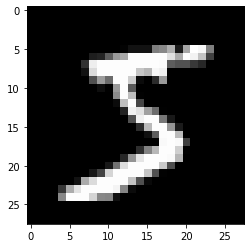

In [8]:
import matplotlib.pyplot as plt
plt.imshow(im.asnumpy())
plt.show()

Ok, that's a beautiful five. 

## Load the data iterator

Now let's load these images into a data iterator so we don't have to do the heavy lifting. 

In [9]:
batch_size = 64
train_data = mx.gluon.data.DataLoader(mnist_train, batch_size, shuffle=True)

We're also going to want to load up an iterator with *test* data. After we train on the training dataset we're going to want to test our model on the test data. Otherwise, for all we know, our model could be doing something stupid (or treacherous?) like memorizing the training examples and regurgitating the labels on command.

In [10]:
test_data = mx.gluon.data.DataLoader(mnist_test, batch_size, shuffle=False)

## Allocate model parameters

Now we're going to define our model. For this example, we're going to ignore the multimodal structure of our data and just flatten each image into a single 1D vector with 28x28 = 784 components. Because our task is multiclass classification, we want to assign a probability to each of the classes $P(Y = c \mid X)$ given the input $X$. In order to do this we're going to need one vector of 784 weights for each class, connecting each feature to the corresponding output. Because there are 10 classes, we can collect these weights together in a 784 by 10 matrix.

We'll also want to allocate one offset for each of the outputs. We call these offsets the *bias term* and collect them in the 10-dimensional array ``b``.

In [11]:
W = nd.random_normal(shape=(num_inputs, num_outputs),ctx=model_ctx)
b = nd.random_normal(shape=num_outputs,ctx=model_ctx)

params = [W, b]

As before, we need to let MXNet know that we'll be expecting gradients corresponding to each of these parameters during training.

In [12]:
for param in params:
    param.attach_grad()

## Multiclass logistic regression

In the linear regression tutorial, we performed regression, so we had just one output $\hat{y}$ and tried to push this value as close as possible to the true target $y$. Here, instead of regression, we are performing *classification*, where we want to assign each input $X$ to one of $L$ classes. 

The basic modeling idea is that we're going to linearly map our input $X$ onto 10 different real valued outputs ``y_linear``. Then, before outputting these values, we'll want to normalize them so that they are non-negative and sum to 1. This normalization allows us to interpret the output $\hat{y}$ as a valid probability distribution.



In [13]:
def softmax(y_linear):
    exp = nd.exp(y_linear-nd.max(y_linear, axis=1).reshape((-1,1)))
    norms = nd.sum(exp, axis=1).reshape((-1,1))
    return exp / norms

In [14]:
sample_y_linear = nd.random_normal(shape=(2,10))
sample_yhat = softmax(sample_y_linear)
print(sample_yhat)


[[0.38854712 0.15868284 0.09794893 0.01202093 0.01595045 0.04553349
  0.14224595 0.0314311  0.04231628 0.06532289]
 [0.08514825 0.43826103 0.02771222 0.08836042 0.17408127 0.05132056
  0.02093019 0.06935012 0.03025253 0.01458343]]
<NDArray 2x10 @cpu(0)>


Let's confirm that indeed all of our rows sum to 1. 

In [15]:
print(nd.sum(sample_yhat, axis=1))


[1. 1.]
<NDArray 2 @cpu(0)>


But for small rounding errors, the function works as expected.

## Define the model

Now we're ready to define our model

In [16]:
def net(X):
    y_linear = nd.dot(X, W) + b
    yhat = softmax(y_linear)
    return yhat

## The  cross-entropy loss function

Before we can start training, we're going to need to define a loss function that makes sense when our prediction is a  probability distribution. 

The relevant loss function here is called cross-entropy and it may be the most common loss function you'll find in all of deep learning. That's because at the moment, classification problems tend to be far more abundant than regression problems. 

The basic idea is that we're going to take a target Y that has been formatted as a one-hot vector, meaning one value corresponding to the correct label is set to 1 and the others are set to 0, e.g. ``[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]``. 


The basic idea of cross-entropy loss is that we only care about how much probability the prediction assigned to the correct label. In other words, for true label 2, we only care about the component of yhat corresponding to 2. Cross-entropy attempts to maximize the log-likelihood given to the correct labels.

In [17]:
def cross_entropy(yhat, y):
    return - nd.sum(y * nd.log(yhat+1e-6))

## Optimizer

For this example we'll be using the same stochastic gradient descent (SGD) optimizer as last time.

In [18]:
def SGD(params, lr):    
    for param in params:
        param[:] = param - lr * param.grad

## Write evaluation loop to calculate accuracy

While cross-entropy is nice, differentiable loss function, it's not the way humans usually evaluate performance on multiple choice tasks. More commonly we look at accuracy, the number of correct answers divided by the total number of questions. Let's write an evaluation loop that will take a data iterator and a network, returning the model's accuracy  averaged over the entire dataset.

In [19]:
def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()

Because we initialized our model randomly, and because roughly one tenth of all examples belong to each of the ten classes, we should have an accuracy in the ball park of .10.

In [20]:
evaluate_accuracy(test_data, net)

0.1167

## Execute training loop

In [21]:
epochs = 5
learning_rate = .005

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += nd.sum(loss).asscalar()

            
    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))       

Epoch 0. Loss: 1.3986248908042909, Train_acc 0.8584, Test_acc 0.8641
Epoch 1. Loss: 0.6145956614891688, Train_acc 0.8803667, Test_acc 0.8812
Epoch 2. Loss: 0.5179733416001002, Train_acc 0.8915167, Test_acc 0.8907
Epoch 3. Loss: 0.467394418545564, Train_acc 0.9, Test_acc 0.8956
Epoch 4. Loss: 0.4352422692616781, Train_acc 0.90265, Test_acc 0.9006


## Using the model for prediction
Let's make it more intuitive by picking 10 random data points from the test set and use the trained model for predictions.

(10, 28, 28, 1)


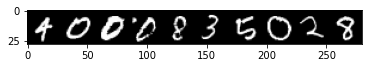

model predictions are: 
[8. 0. 0. 8. 8. 3. 2. 0. 2. 8.]
<NDArray 10 @cpu(0)>


In [22]:
# Define the function to do prediction
def model_predict(net,data):
    output = net(data)
    return nd.argmax(output, axis=1)

# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(mnist_test, 10, shuffle=True)
for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(model_ctx)
    print(data.shape)
    im = nd.transpose(data,(1,0,2,3))
    im = nd.reshape(im,(28,10*28,1))
    imtiles = nd.tile(im, (1,1,3))
    
    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    break

## Conclusion

We can get nearly 90% accuracy at this task just by training a linear model for a few seconds! You might reasonably conclude that this problem is too easy to be taken seriously by experts.

But until recently, many papers (Google Scholar says 13,800) were published using results obtained on this data. While MNIST can be a nice toy dataset for testing new ideas, we don't recommend writing papers with it. 